In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from IPython.display import display, Markdown
import warnings
from datetime import datetime
from pandas_datareader import data as pdr

In [2]:
# Configuration pour de meilleurs graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

In [3]:
# Formatter pour afficher les valeurs en CHF
def chf_format(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f} M CHF'
    elif x >= 1_000:
        return f'{x/1_000:.0f} k CHF'
    else:
        return f'{x:.0f} CHF'

chf_formatter = FuncFormatter(chf_format)

## Objectif de l'analyse

Dans ce notebook, nous allons étudier l'impact des rendements historiques réels du S&P 500 sur notre planification retraite, au lieu d'utiliser un rendement constant de 10% comme dans notre modèle initial.

Les questions que nous allons explorer:
1. Comment les fluctuations réelles des marchés affectent-elles le capital final?
2. Quel serait l'investissement initial nécessaire avec des rendements historiques?
3. Comment la volatilité des marchés influence-t-elle les différentes stratégies d'investissement?

In [5]:
## Partie 1: Récupération et analyse des données historiques du S&P 500

# Téléchargement des données du S&P 500
try:
    start_date = '1957-01-01'  # On essaie de récupérer les données depuis 1957 comme dans notre analyse précédente
    end_date = datetime.today().strftime('%Y-%m-%d')
    print(f"Téléchargement des données du S&P 500 du {start_date} au {end_date}...")
    sp500_data = pdr.get_data_stooq('^SPX', start=start_date, end=end_date)

    # Vérification des colonnes disponibles
    print("\nColonnes disponibles:", sp500_data.columns.tolist())

    # Identification de la colonne de prix à utiliser
    if 'Adj Close' in sp500_data.columns:
        price_column = 'Adj Close'
    elif 'Close' in sp500_data.columns:
        price_column = 'Close'
    else:
        price_column = sp500_data.columns[0]

    print(f"Colonne de prix utilisée: '{price_column}'")

SyntaxError: incomplete input (772098451.py, line 21)

Téléchargement des données du S&P 500 du 1957-01-01 au 2025-03-18...

Colonnes disponibles: ['Open', 'High', 'Low', 'Close', 'Volume']
Colonne de prix utilisée: 'Close'

Aperçu des données téléchargées:
               Open     High      Low    Close        Volume
Date                                                        
2025-03-17  5635.60  5703.52  5631.12  5675.12  2.988688e+09
2025-03-14  5563.85  5645.27  5563.85  5638.94  3.014215e+09
2025-03-13  5594.45  5597.78  5504.65  5521.52  3.339959e+09
2025-03-12  5624.84  5642.19  5546.09  5599.30  3.479733e+09
2025-03-11  5603.65  5636.30  5528.41  5572.07  4.149152e+09

Période couverte: du 02-01-1957 au 17-03-2025
Nombre total de jours de trading: 17167

Valeurs manquantes par colonne:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Rendements annuels du S&P500:
            Annual_Return_%  Year
Date                             
1958-12-31        38.059515  1958
1959-12-31         8.476725  1959
1960-12-31

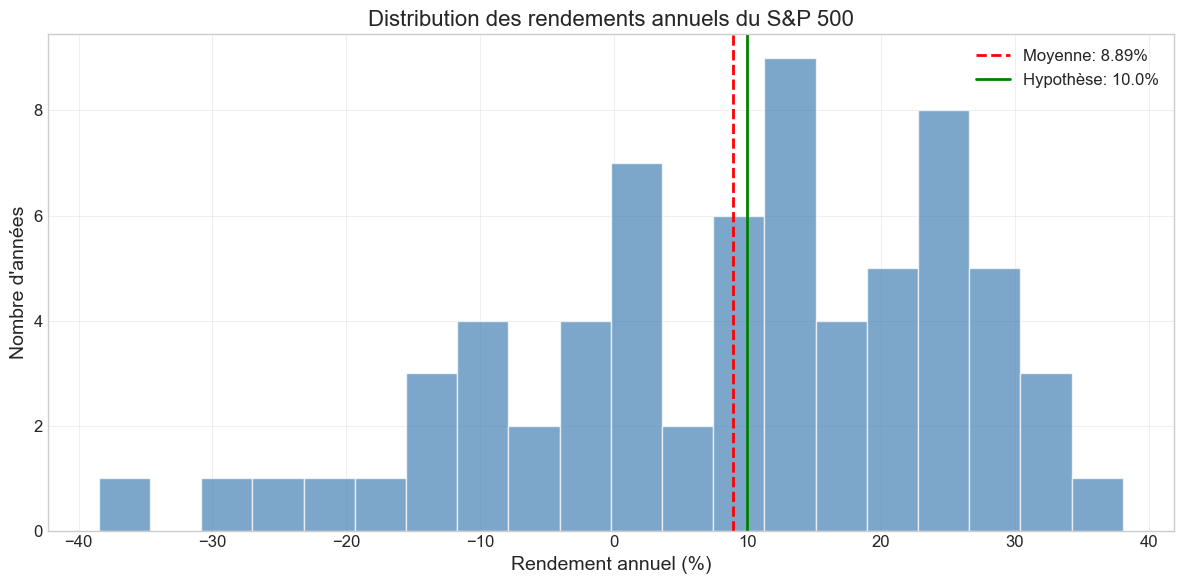

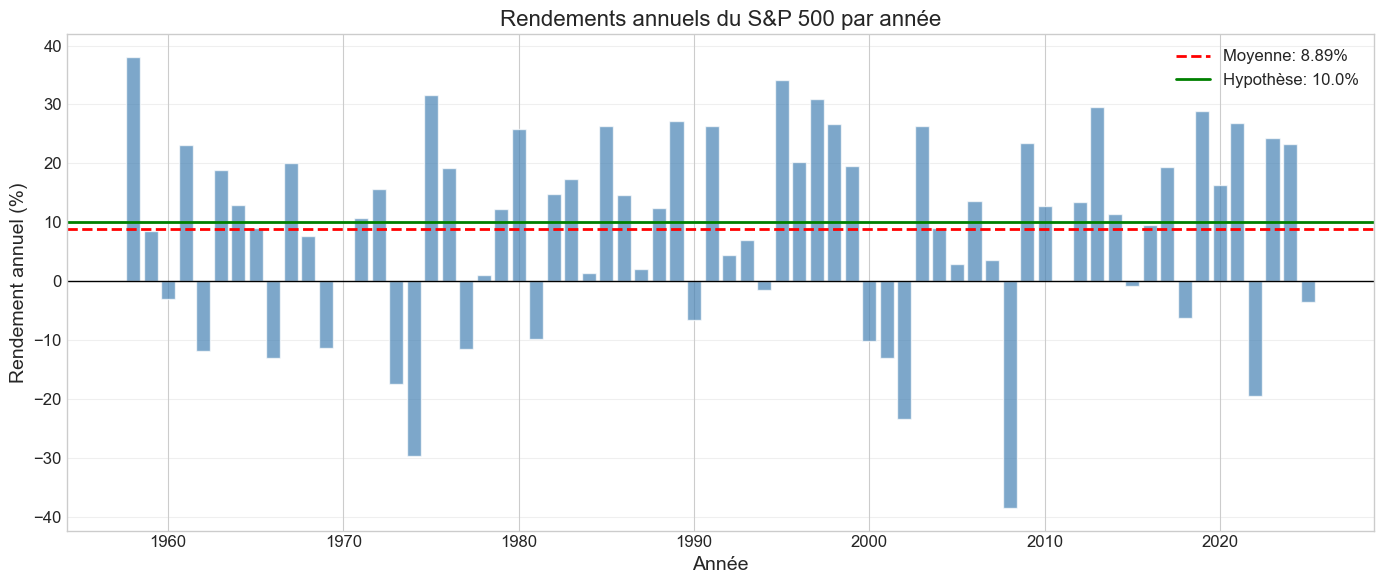

In [6]:
## Partie 1: Récupération et analyse des données historiques du S&P 500

# Téléchargement des données du S&P 500
try:
    start_date = '1957-01-01'  # On essaie de récupérer les données depuis 1957 comme dans notre analyse précédente
    end_date = datetime.today().strftime('%Y-%m-%d')
    print(f"Téléchargement des données du S&P 500 du {start_date} au {end_date}...")
    sp500_data = pdr.get_data_stooq('^SPX', start=start_date, end=end_date)

    # Vérification des colonnes disponibles
    print("\nColonnes disponibles:", sp500_data.columns.tolist())

    # Identification de la colonne de prix à utiliser
    if 'Adj Close' in sp500_data.columns:
        price_column = 'Adj Close'
    elif 'Close' in sp500_data.columns:
        price_column = 'Close'
    else:
        price_column = sp500_data.columns[0]

    print(f"Colonne de prix utilisée: '{price_column}'")

    # Aperçu des données
    print("\nAperçu des données téléchargées:")
    print(sp500_data.head())

    # Informations sur les données
    print(f"\nPériode couverte: du {sp500_data.index.min().strftime('%d-%m-%Y')} au {sp500_data.index.max().strftime('%d-%m-%Y')}")
    print(f"Nombre total de jours de trading: {len(sp500_data)}")

    # Vérification des valeurs manquantes
    missing_values = sp500_data.isna().sum()
    print("\nValeurs manquantes par colonne:")
    print(missing_values)

    # Suppression des lignes avec des valeurs manquantes si nécessaire
    if sp500_data[price_column].isna().sum() > 0:
        print(f"Suppression des {sp500_data[price_column].isna().sum()} lignes avec des valeurs manquantes...")
        sp500_data = sp500_data.dropna(subset=[price_column])

    # Calcul des rendements annuels
    # Resample pour obtenir le dernier prix ajusté de chaque année
    annual_prices = sp500_data[price_column].resample('Y').last()

    # Calcul des rendements annuels en pourcentage
    annual_returns = annual_prices.pct_change() * 100
    annual_returns = annual_returns.dropna()

    # Création d'un DataFrame avec l'année
    annual_df = pd.DataFrame(annual_returns)
    annual_df.columns = ['Annual_Return_%']
    annual_df['Year'] = annual_df.index.year

    # Aperçu des rendements annuels
    print("\nRendements annuels du S&P500:")
    print(annual_df)

    # Statistiques des rendements annuels
    print("\nStatistiques des rendements annuels:")
    print(annual_df['Annual_Return_%'].describe())

    # Extraction des rendements annuels en liste
    sp500_returns_historical = annual_df['Annual_Return_%'].values.tolist()

except Exception as e:
    print(f"Erreur lors du téléchargement des données: {e}")
    print("Utilisation des rendements historiques approximatifs comme solution de repli...")

    # Rendements historiques approximatifs du S&P 500 (1957-2024) comme solution de repli
    sp500_returns_historical = [
      # 1957-1969
      -10.8, 38.1, 8.5, 0.3, 23.1, -8.7, 18.9, 13.0, 9.1, -10.1, 20.1, 7.7, -8.5,
      # 1970-1979
      0.1, 10.8, 15.6, -17.4, -29.7, 31.5, 19.2, -11.5, 1.1, 12.3,
      # 1980-1989
      25.8, -9.7, 14.8, 17.3, 1.4, 26.3, 14.6, 2.0, 12.4, 27.3,
      # 1990-1999
      -6.6, 26.3, 4.5, 7.1, -1.5, 34.1, 20.3, 31.0, 26.7, 19.5,
      # 2000-2009
      -10.1, -13.0, -23.4, 26.4, 9.0, 3.0, 13.6, 3.5, -38.5, 23.5,
      # 2010-2019
      12.8, 0.0, 13.4, 29.6, 11.4, -0.7, 9.5, 19.4, -6.2, 28.9,
      # 2020-2024 (approximation)
      16.3, 26.9, -19.4, 24.2, 20.0
    ]

    # Création d'un DataFrame avec les données de secours
    annual_df = pd.DataFrame({
        'Annual_Return_%': sp500_returns_historical,
        'Year': range(1957, 1957 + len(sp500_returns_historical))
    })
    print("\nUtilisation des rendements historiques approximatifs:")
    print(annual_df)

# Caractéristiques statistiques des rendements
average_return = np.mean(sp500_returns_historical)
# Calcul du CAGR (Compound Annual Growth Rate)
cagr = np.exp(np.log(1 + np.array(sp500_returns_historical) / 100).mean()) - 1
std_dev = np.std(sp500_returns_historical)
worst_return = min(sp500_returns_historical)
worst_year_idx = sp500_returns_historical.index(worst_return)
worst_year = annual_df['Year'].iloc[worst_year_idx]
best_return = max(sp500_returns_historical)
best_year_idx = sp500_returns_historical.index(best_return)
best_year = annual_df['Year'].iloc[best_year_idx]

# Afficher les statistiques
print(f"\nNombre d'années de données historiques: {len(sp500_returns_historical)}")
print(f"Rendement moyen arithmétique: {average_return:.2f}%")
print(f"Rendement composé annualisé (CAGR): {cagr*100:.2f}%")
print(f"Écart-type (volatilité): {std_dev:.2f}%")
print(f"Pire année: {worst_year} avec {worst_return:.1f}%")
print(f"Meilleure année: {best_year} avec {best_return:.1f}%")

# Visualisation de la distribution des rendements
plt.figure(figsize=(12, 6))
plt.hist(sp500_returns_historical, bins=20, alpha=0.7, color='steelblue')
plt.axvline(x=average_return, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {average_return:.2f}%')
plt.axvline(x=10, color='green', linestyle='-', linewidth=2, label='Hypothèse: 10.0%')
plt.title('Distribution des rendements annuels du S&P 500', fontsize=16)
plt.xlabel('Rendement annuel (%)', fontsize=14)
plt.ylabel('Nombre d\'années', fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Visualisation de l'évolution des rendements au fil du temps
plt.figure(figsize=(14, 6))
plt.bar(annual_df['Year'], annual_df['Annual_Return_%'], alpha=0.7, color='steelblue')
plt.axhline(y=average_return, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {average_return:.2f}%')
plt.axhline(y=10, color='green', linestyle='-', linewidth=2, label='Hypothèse: 10.0%')
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.title('Rendements annuels du S&P 500 par année', fontsize=16)
plt.xlabel('Année', fontsize=14)
plt.ylabel('Rendement annuel (%)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### Observations sur les rendements historiques

Les statistiques ci-dessus révèlent plusieurs points importants:

1. **Rendement versus hypothèse**:
   - Rendement moyen arithmétique réel: {:.2f}%
   - Rendement composé annualisé (CAGR): {:.2f}%
   - Notre hypothèse constante: 10.0%

2. **Volatilité significative**:
   - Écart-type de {:.2f}%, indiquant des fluctuations importantes
   - Amplitude entre le pire ({:.1f}%) et le meilleur ({:.1f}%) rendement: {:.1f}%

3. **Distribution asymétrique**:
   - Le rendement moyen est supérieur au rendement médian
   - Présence de rendements négatifs importants qui impactent fortement la performance à long terme

Cette volatilité explique pourquoi le CAGR est inférieur au rendement moyen arithmétique, et pourquoi notre modèle à rendement constant de 10% était trop optimiste.